# Imports

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchvision
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from dateutil import parser
import librosa
import librosa.display
import os
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io import wavfile

using gpu 0


## Folders, files and timestamps defined

Before you start: put the audio file(s) in the correct input folder and reference it correctly below

In [2]:
input_folder = "./audio/"
labels_path = "conversation_labels.npy"
labels_conv_path = "conversation_convlabels.npy"
voice_yesno_model = "voice_detection_model"
voice_comparison_model = "voice_comparison_model"
with_timestamps = False
output_spectro = "OutputSpectro.npy"
output_mfcc = "OutputMFCC.npy"

## Classes

In [3]:
class Second:
  def __init__(self, timestamp, data):
    self.timestamp = timestamp
    self.data = data

# Dataloading & converting to MFCC & Spectrograms

In case off RuntimeError: Error opening './audio/.ipynb_checkpoints': Format not recognised.
Go to terminal, go to correct folder and rm -r .ipynb_checkpoints 

In [4]:
audioFragmentsSpectro = []
audioFragmentsMFCC = []
for filename in os.listdir(input_folder):
    if(with_timestamps):
        timestamp = Path(filename).stem
        parsedtimestamp = parser.parse(timestamp)
    
    samples, sampleRate = sf.read(input_folder + filename)
    #resamples the samples to sampling rate of 44100
    if not sampleRate == 44100:
        samples = librosa.resample(samples, sampleRate, 44100)
        sampleRate = 44100
    halfSecondSamples = sampleRate/2
    #disregards the last audio sample if it is less than half a second
    samples = samples[:int((len(samples)-(len(samples) % halfSecondSamples)))]
    array = np.reshape(samples, (int(samples.size/halfSecondSamples), int(halfSecondSamples)))
    for index, sample in enumerate(array):
        if(with_timestamps):
            td = datetime.timedelta(0,index)
            increasedparsedtimestamp = parsedtimestamp + td

        mfcc = librosa.feature.mfcc(y = sample, sr = sampleRate, n_mfcc=40)
        spectrogram = librosa.feature.melspectrogram(sample, sr=sampleRate)
        mfccArray = np.array(mfcc)
        spectrogramArray = np.array(spectrogram)
        if(with_timestamps):
            mfccArray = Second(increasedparsedtimestamp, mfccArray)
            spectrogramArray = Second(increasedparsedtimestamp, spectrogramArray)
        audioFragmentsMFCC.append(mfccArray)
        audioFragmentsSpectro.append(spectrogramArray)

## Checking results of converting the data

In [5]:
print("Amount of halfseconds: "+str(len(audioFragmentsSpectro)))
print("Amount of halfseconds: "+str(len(audioFragmentsMFCC)))
if(with_timestamps):
    print("Timestamp 1: "+str(audioFragmentsMFCC[0].timestamp))
    print("Timestamp 2: "+str(audioFragmentsMFCC[1].timestamp))
    print("Timestamp 3: "+str(audioFragmentsMFCC[2].timestamp))
    print("Spectrogram shape: "+str(len(audioFragmentsSpectro[0].data))+", "+str(len(audioFragmentsSpectro[0].data[0])))
    print("MFCC shape: "+str(len(audioFragmentsMFCC[0].data))+", "+str(len(audioFragmentsMFCC[0].data[0])))
#    for frag in audioFragmentsMFCC:
#        print(len(frag.data),"||", frag.timestamp)
else:
    print("Spectrogram shape: "+str(len(audioFragmentsSpectro[0]))+", "+str(len(audioFragmentsSpectro[0][0])))
    print("MFCC shape: "+str(len(audioFragmentsMFCC[0]))+", "+str(len(audioFragmentsMFCC[0][0])))

Amount of halfseconds: 1248
Amount of halfseconds: 1248
Spectrogram shape: 128, 44
MFCC shape: 40, 44


# Defining the voice detection CNN Model

In [6]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()        
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=7, stride = 1, padding= 3, padding_mode= 'zeros') #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=5, stride = 1, padding = 2, padding_mode= 'zeros') #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(60, 70, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')
        self.conv4 = nn.Conv1d(70, 80, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')

        self.fc1 = nn.Linear(160, 100) #Fully-connected classifier layer
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50,1) #Fully-connected classifier layer

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        x = F.relu(F.max_pool1d(self.conv4(x), 2))
        x = x.reshape(len(x), -1)

#point A
#point B
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

    def post_forward(self, y):

        return torch.round(y)        

# Loading & preparing by resizing the data for the first model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = torch.Tensor(audioFragmentsMFCC).float()
data = data.to(device)

/tmp/ipykernel_12082/3960119229.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.Tensor(audioFragmentsMFCC).float()


# Loading and preparing trained voice recognition model

In [8]:
CNN = model(data.shape[1], 7)
CNN.load_state_dict(torch.load(voice_yesno_model), strict=False)
CNN = CNN.to(device)

# Executing the first model on data

In [9]:
y_pred = CNN(data)
y_pred = y_pred.ge(.5).view(-1).cpu()

# Load in labels

In [10]:
labels_seconds = np.load(labels_path, allow_pickle = True)

# y_pred from Tensor to Numpy array

In [11]:
predictions = y_pred.numpy()

# Labels in this case were for full seconds so we double the amount of labels and create a labels array with only true and false

In [12]:
preds = predictions[:(len(labels_seconds)*2)]
labels = []
labels_TF = []
for label in labels_seconds:
    if(label.startswith("False")):
        label = False        
    else:
        label = label.astype(int)
    labels.append(label)
    labels.append(label)
    
for label in labels_seconds:
    if(label.startswith("False")):
        label = False        
    else:
        label = True
    labels_TF.append(label)
    labels_TF.append(label)

#### labels: labels with speaker ids
#### labels_TF: labels with only true or false for speech

In [13]:
print(labels[330:340])

[89, 89, 89, 89, False, False, False, False, False, False]


In [14]:
print(labels_TF[330:340])

[True, True, True, True, False, False, False, False, False, False]


# Printing out accuracy

In [15]:
correct = []
for i in range(len(preds)):
    correct.append(preds[i] == bool(labels_TF[i]))
print(len(correct))
print(correct.count(True))
format_float = "{:.2f}".format(correct.count(True)/len(correct)*100)
print(str(format_float)+"%")

1248
1097
87.90%


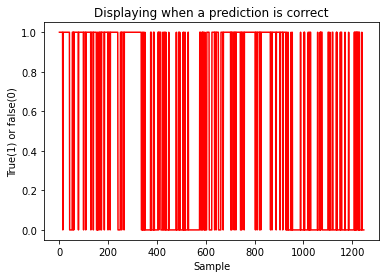

In [16]:
plt.plot(range(0, len(preds)), preds, 'r')
plt.title("Displaying when a prediction is correct")
plt.xlabel('Sample')
plt.ylabel('True(1) or false(0)')
plt.show()

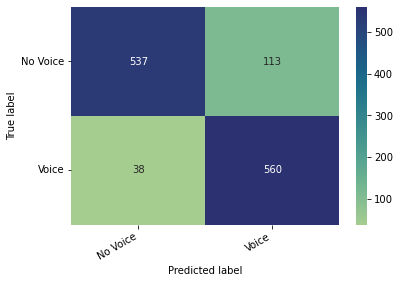

In [17]:
classes = ['No Voice', 'Voice']
cm = confusion_matrix(labels_TF[:len(preds)], preds)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [18]:
format_float = "{:.2f}".format(preds.sum()/len(preds)*100)
percentage_spoken = str(format_float)
print(str(percentage_spoken)+"% of the time there was speech")

53.93% of the time there was speech


# 

# 

# 

# Create a list of the true-labeled data and their respective labels

In [19]:
count_true = np.count_nonzero(y_pred) 
pos_voice_result = np.empty((count_true, len(audioFragmentsMFCC[0]), len(audioFragmentsMFCC[0][0])))
labels_T = []
index = 0
for i in range(0, len(y_pred)):
    if(y_pred[i]):   
        pos_voice_result[index] = audioFragmentsMFCC[i]
        labels_T.append(labels[i])
        index +=1
labels_T.append(labels_T[0])

# Create a second list of the true-labeled data, but all samples are moved one spot up and the last becomes the first

In [20]:
pos_voice_result_2 = pos_voice_result[1:]
pos_voice_result_2 = np.concatenate((pos_voice_result_2, np.expand_dims(pos_voice_result[0], axis=0)))
print(len(pos_voice_result_2))
print(pos_voice_result_2.shape)
print(len(pos_voice_result))
print(pos_voice_result.shape)

673
(673, 40, 44)
673
(673, 40, 44)


# Defining the voice comparison CNN model

In [21]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=7, stride = 1, padding = 3, padding_mode= 'zeros') #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=5, stride = 1, padding = 2, padding_mode= 'zeros') #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(60, 70, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')
        self.conv4 = nn.Conv1d(70, 80, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')

        self.fc1 = nn.Linear(320, 200) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        x = F.relu(F.max_pool1d(self.conv4(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)

# Loading & preparing by resizing the data for the second model

In [22]:
data_speaker1 = pos_voice_result
data_speaker2 = pos_voice_result_2
data_speaker1_torch = torch.from_numpy(data_speaker1).float()
data_speaker2_torch = torch.from_numpy(data_speaker2).float()

data_speaker_ds = TensorDataset(data_speaker1_torch, data_speaker2_torch)

batch_size = 32
data_speaker_dl = DataLoader(data_speaker_ds, batch_size=batch_size, num_workers = 4, pin_memory = True)

# Loading and preparing trained voice comparison model

In [23]:
CNN = model(data_speaker1_torch.shape[1], 3)
CNN.load_state_dict(torch.load("voice_comparison_model"), strict=False)

<All keys matched successfully>

# Executing the CNN

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = CNN.to(device)
c = 0
listOfYPreds = []
for x1, x2 in data_speaker_dl:
    x1, x2 = x1.to(device), x2.to(device)
    y_pred = CNN(x1, x2)
    y_pred = y_pred.ge(.5).view(-1).cpu()
    c = c + 1
    listOfYPreds.append(y_pred)
print(c)
print(device)

22
cuda


# Obtaining all true and false labels in one list

In [25]:
predictions = []
for i in listOfYPreds:
    for v in i:
        predictions.append(v)    
print(len(predictions))
print(predictions.count(True))
print(predictions.count(False))
timesSpeakerChanged = predictions.count(False)

673
559
114


In [26]:
correct = []
print(len(labels_T))
for index, pred in enumerate(predictions):
    theSame = labels_T[index] == labels_T[index+1]
    correct.append(pred == theSame)

674


In [30]:
print(len(correct))
print(correct.count(True))
format_float = "{:.2f}".format(correct.count(True)/len(correct)*100)
print(str(format_float)+"%")

673
573
85.14%


# Plotting the data

53.93% of the audio contains speech.
During this speech audio, 114 times the speaker changed.


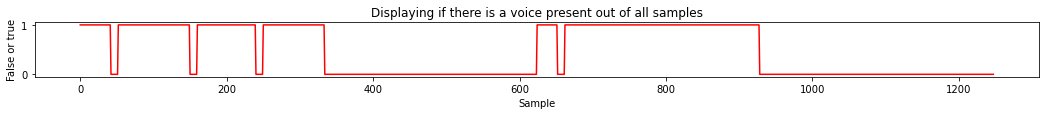

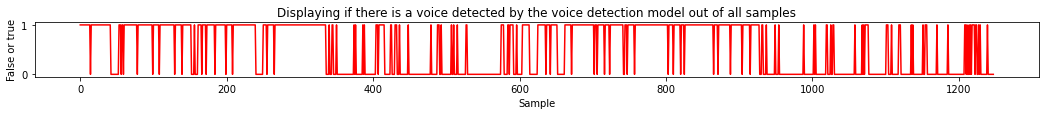

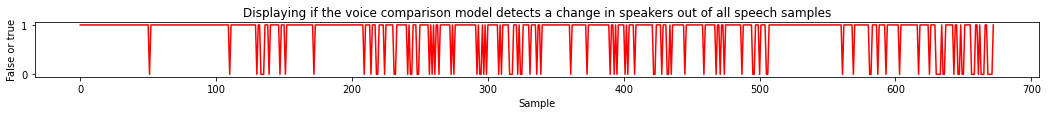

In [57]:
plt.figure(figsize=(18,1))
plt.plot(range(0, len(labels_TF)), labels_TF, 'r')
plt.title("Displaying if there is a voice present out of all samples")
plt.xlabel('Sample')
plt.ylabel('False or true')
plt.figure(figsize=(18,1))
plt.plot(range(0, len(preds)), preds, 'r')
plt.title("Displaying if there is a voice detected by the voice detection model out of all samples")
plt.xlabel('Sample')
plt.ylabel('False or true')
plt.figure(figsize=(18,1))
plt.plot(range(0, len(correct)), correct, 'r')
plt.title("Displaying if the voice comparison model detects a change in speakers out of all speech samples")
plt.xlabel('Sample')
plt.ylabel('False or true')
print(str(percentage_spoken)+"% of the audio contains speech.")
print("During this speech audio, "+str(timesSpeakerChanged)+" times the speaker changed.")
